In [1]:
import os
# Set ALL environment variables before any imports
os.environ.update({
    "TORCH_COMPILE_DISABLE": "1",
    "PYTORCH_DISABLE_TRITON": "1", 
    "TRITON_DISABLE_LINE_INFO": "1",
    "K_DIFFUSION_USE_FLASH_2": "0",
    "CUDA_VISIBLE_DEVICES": "",
    "PYTORCH_JIT": "0"
})

import sys
import torch
from models.strand_codec import StrandCodec

# Simple clean approach
vae_model = StrandCodec()
checkpoint = torch.load('./checkpoints/strand_vae/strand_codec.pt', map_location='cpu')
vae_model.load_state_dict(checkpoint)
vae_model.eval()

decoder = vae_model.decoder
print("Decoder loaded successfully!")

Decoder loaded successfully!


/var/folders/6c/1m8nyt515lq2hdz8yp5pydl40000gn/T/ipykernel_5953/3084371562.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./checkpoints/strand

In [2]:
# Dummy input
z = torch.randn(1, 64)

# Minimal hyperparams and normalization dict
class DummyHyperparams:
    normalize_input = False

dummy_hparams = DummyHyperparams()
dummy_norm = {
    "xyz_mean": torch.zeros(3),
    "xyz_std": torch.ones(3),
    "dir_mean": torch.zeros(3),
    "dir_std": torch.ones(3)
}

# Decode
with torch.no_grad():
    strand_output = decoder(z, dummy_hparams, dummy_norm)

strand = strand_output['strand_positions']
print("Decoded strand shape:", strand.shape)

Decoded strand shape: torch.Size([1, 256, 3])


In [3]:
# Cell 1: Load & inspect three strands + their 64D latents
import numpy as np
import torch

base_name = "uggams_3"  
folder   = "./outputs_inference"

scalp_texture_npz_path  = f"{folder}/{base_name}_scalp_texture.npz"
output_strands_npz_path = f"{folder}/{base_name}_output_strands.npz"

# ─────────────────────────────────────────────
# 2) Load & print the “scalp‐texture” file
print("\n=== Scalp‐Texture File ===")
scalp_data = np.load(scalp_texture_npz_path)
print("Keys in scalp‐texture .npz:", scalp_data.files)
for key in scalp_data.files:
    arr = scalp_data[key]
    print(f"  • '{key}': shape = {arr.shape}, dtype = {arr.dtype}")

#   We expect:
#     'scalp_texture': shape = (1, 65, 256, 256)
#
#   – First 64 channels = the 64‐D latent at each (u,v)
#   – 65th channel = density

# ─────────────────────────────────────────────
# 3) Load & print the “output‐strands” file
print("\n=== Output‐Strands File ===")
strands_data = np.load(output_strands_npz_path)
print("Keys in output‐strands .npz:", strands_data.files)
for key in strands_data.files:
    arr = strands_data[key]
    print(f"  • '{key}': shape = {arr.shape}, dtype = {arr.dtype}")

#   We expect:
#     'positions': shape = (N_strands, 256, 3)
#       → N_strands might be ∼100K, each with (256,3) points.

# ─────────────────────────────────────────────
# 4) Print the full (256×3) array for the first 3 strands
all_strands_np = strands_data['positions']    # shape = (N_strands, 256, 3)
num_strands   = all_strands_np.shape[0]
print(f"\nTotal number of strands: {num_strands}")
print(f"Each strand has shape: {all_strands_np.shape[1:]}  # (256, 3)\n")

for idx in range(3):
    strand_np = all_strands_np[idx]  # (256,3)
    print(f"--- Strand #{idx} (256×3 points) ---")
    print(strand_np, "\n")

# ─────────────────────────────────────────────
# 5) Print the 64-D latent for those same 3 strands
scalp_tex = scalp_data['scalp_texture']  # shape = (1, 65, 256, 256)

for idx in range(3):
    u, v = 0, idx  # pick texels (0,0), (0,1), (0,2) in order
    latent_np = scalp_tex[0, 0:64, u, v]    # shape = (64,)
    print(f"--- Strand #{idx}’s 64-D latent (from texel ({u},{v})) ---")
    print(latent_np)
    print("Shape of that latent:", latent_np.shape, "\n")

# ─────────────────────────────────────────────
# 6) (Optional) Convert the first of these three to torch.Tensor
first_strand_t = torch.from_numpy(all_strands_np[0]).float()   
first_latent_t = torch.from_numpy(scalp_tex[0, 0:64, 0, 0]).float()

print("Converted first strand to torch.Tensor:")
print("  • first_strand_t.shape =", first_strand_t.shape)
print("  • first_latent_t.shape =", first_latent_t.shape)



=== Scalp‐Texture File ===
Keys in scalp‐texture .npz: ['scalp_texture']
  • 'scalp_texture': shape = (1, 65, 256, 256), dtype = float32

=== Output‐Strands File ===
Keys in output‐strands .npz: ['positions']
  • 'positions': shape = (132479, 256, 3), dtype = float32

Total number of strands: 132479
Each strand has shape: (256, 3)  # (256, 3)

--- Strand #0 (256×3 points) ---
[[0.0594619  0.3192279  0.05253663]
 [0.05949565 0.3193744  0.05266375]
 [0.0594837  0.31952703 0.05279867]
 [0.0595995  0.3196395  0.05288682]
 [0.05974879 0.3197249  0.05295866]
 [0.05990575 0.3198084  0.05302735]
 [0.06006704 0.31989098 0.05309425]
 [0.06023136 0.31997213 0.05315981]
 [0.06039818 0.32005173 0.05322344]
 [0.06056561 0.32012925 0.05328612]
 [0.0607319  0.32020375 0.05334926]
 [0.06089607 0.32027465 0.05341344]
 [0.0610572  0.32034165 0.0534789 ]
 [0.06121381 0.32040456 0.05354597]
 [0.06136448 0.3204633  0.05361542]
 [0.06150743 0.320518   0.0536879 ]
 [0.06164014 0.32056883 0.05376396]
 [0.0617

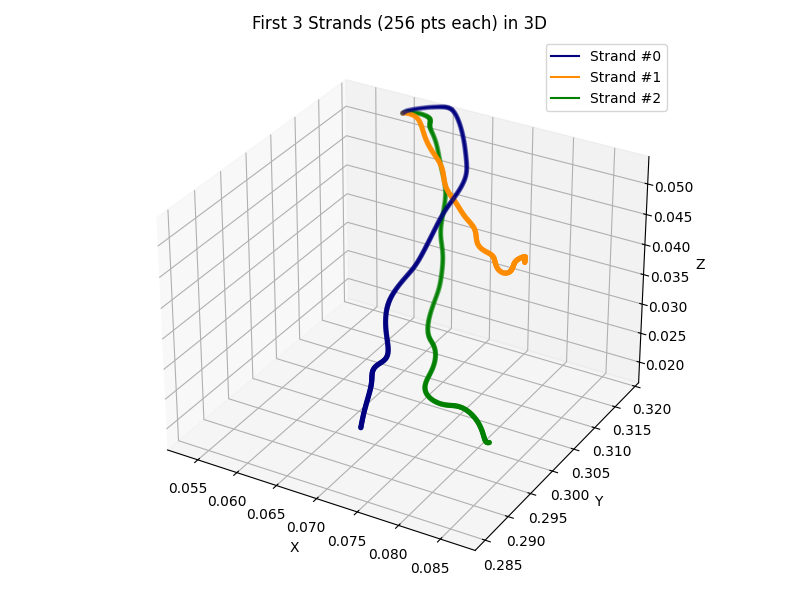

In [4]:
# Cell 2: Visualize the first 3 strands (256 points each) in a single 3D plot,
#          save to PNG, and display it.

import os
import numpy as np

# 1) Create (or ensure) a local config dir for Matplotlib if needed
os.makedirs("./tmp_matplotlib_config", exist_ok=True)
os.environ["MPLCONFIGDIR"] = os.path.abspath("./tmp_matplotlib_config")
os.environ["MPLBACKEND"]   = "Agg"    # Use Agg backend

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401
from IPython.display import Image, display

# 2) Reload strands data and grab the first 3 strands:
strands_data = np.load("./outputs_inference/hathaway_1_output_strands.npz")
all_strands  = strands_data["positions"]  # shape = (N_strands, 256, 3)

# Make sure there are at least 3:
assert all_strands.shape[0] >= 3, "Need at least 3 strands in the file."

# Choose distinct colors for each:
colors = ["navy", "darkorange", "green"]

fig = plt.figure(figsize=(8, 6))
ax  = fig.add_subplot(111, projection="3d")

for idx, color in zip(range(3), colors):
    strand_np = all_strands[idx]  # (256, 3)
    xs = strand_np[:, 0]
    ys = strand_np[:, 1]
    zs = strand_np[:, 2]
    ax.plot(xs, ys, zs, color=color, linewidth=1.5, label=f"Strand #{idx}")
    ax.scatter(xs, ys, zs, color=color, s=8)

# 3) Tidy up axes, labels, legend:
ax.set_title("First 3 Strands (256 pts each) in 3D")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

# 4) Equal aspect ratio
all_points = np.concatenate([all_strands[0], all_strands[1], all_strands[2]], axis=0)
xmin, xmax = all_points[:,0].min(), all_points[:,0].max()
ymin, ymax = all_points[:,1].min(), all_points[:,1].max()
zmin, zmax = all_points[:,2].min(), all_points[:,2].max()
max_range = max(xmax - xmin, ymax - ymin, zmax - zmin) / 2.0
mid_x = (xmax + xmin) / 2.0
mid_y = (ymax + ymin) / 2.0
mid_z = (zmax + zmin) / 2.0
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.tight_layout()

# 5) Save & display:
out_png = "three_strands_3d_plot.png"
fig.savefig(out_png)
plt.close(fig)

display(Image(filename=out_png))


In [5]:
import numpy as np

def strand_guide_length(strand):
    """
    Given a single strand of shape (256, 3), find the maximum
    Euclidean distance between any two points in that strand.
    
    Parameters:
      - strand: a NumPy array of shape (256, 3)
    
    Returns:
      - max_dist: a float, the largest distance between any two points
    """
    # Ensure input is a NumPy array of shape (256, 3)
    strand = np.asarray(strand)
    assert strand.ndim == 2 and strand.shape[1] == 3, \
        "Input must be shape (256, 3)"
    
    # Compute all pairwise squared distances (256×256 matrix)
    diff = strand[np.newaxis, :, :] - strand[:, np.newaxis, :]  # shape = (256, 256, 3)
    d2 = np.sum(diff * diff, axis=2)                             # shape = (256, 256)
    
    # Take the maximum squared distance, then sqrt it
    max_d2 = np.max(d2)
    max_dist = float(np.sqrt(max_d2))
    return max_dist


def straightened_length(strand):
    """
    Given one strand as shape (L, 3), return its “straightened length”—
    i.e. the polyline length obtained by summing ||p[i+1] - p[i]||.
    """
    # Differences between successive points: shape (L-1, 3)
    deltas = strand[1:] - strand[:-1]
    # Euclidean lengths of each segment
    seg_lengths = np.linalg.norm(deltas, axis=1)  # shape (L-1,)
    return np.sum(seg_lengths)


def curl_diameter(strand):
    """
    Given one strand (L, 3), approximate its “curl diameter” by:
      1. Finding the principal growth axis via PCA (first singular vector).
      2. Projecting all points into the plane orthogonal to that axis.
      3. Returning the maximum pairwise distance in that 2D projection.
    This approximates how “wide” its coil is.
    """
    # 1) Center the points, do an SVD to get principal axis
    pts = strand - strand.mean(axis=0)  # center at origin
    # Compute covariance (3×3) or directly do SVD on pts (L×3)
    # SVD: pts = U Σ V^T  → rows of V^T are principal axes.
    # We only need the first principal axis:
    _, _, Vt = np.linalg.svd(pts, full_matrices=False)
    # principal axis = Vt[0]  (unit‐length)
    principal_axis = Vt[0, :]  # shape (3,)
    
    # 2) Project each point onto the plane perp to principal_axis:
    # If v is the axis, projection onto orth plane is: p_perp = p - (p·v) v
    v = principal_axis
    proj_perp = pts - np.outer(np.dot(pts, v), v)  # shape (L, 3)
    
    # Now choose any two orthonormal directions in that plane as “x,y”
    # We can do this by completing an orthonormal basis:
    #   find a vector not parallel to v, cross(v, that) → e1, then e2 = cross(v,e1)
    # But since proj_perp is already in plane, we can just perform a 2D PCA on proj_perp.
    # Simpler: ignore the “third” coordinate of proj_perp in the direction of principal_axis
    # Actually proj_perp is guaranteed to be ⟂ v → but still 3D. Let's pick two largest‐variance dims.
    # We'll compute SVD on proj_perp itself:
    U2, S2, Vt2 = np.linalg.svd(proj_perp, full_matrices=False)
    # Vt2[0], Vt2[1] are two orthonormal directions in the perp‐plane.
    e1 = Vt2[0, :]
    e2 = Vt2[1, :]
    # Now project onto (e1,e2) to obtain 2D coordinates:
    coords2d = np.stack([pts.dot(e1), pts.dot(e2)], axis=1)  # shape (L, 2)
    
    # 3) Compute max pairwise distance in that 2D cloud:
    # (again, O(L^2) if L~256 is fine)
    diffs2 = coords2d[np.newaxis, :, :] - coords2d[:, np.newaxis, :]  # (L, L, 2)
    d2_2d = np.sum(diffs2**2, axis=2)
    max_diam = np.sqrt(np.max(d2_2d))
    
    return max_diam


def curl_frequency(strand, smoothing_window=5, min_peak_height=0.01):
    """
    Approximate the number of full “loops” (oscillations) in a single strand.
    Steps:
      1. Compute the principal growth axis via PCA.
      2. Project each point onto that axis → get a 1D coordinate t[i].
      3. For each point, compute radial distance r[i] = || p[i] - (t[i]·axis) axis ||.
      4. Smooth r[i] slightly, then count the number of peaks above a small threshold.
    Returns:
      - freq = number_of_peaks / total_axis_length   (loops per unit length)
      - n_peaks = total peaks counted
      - axis_length = max(t) - min(t)
    """
    # 1) PCA to get principal axis
    pts = strand - strand.mean(axis=0)  # center
    _, _, Vt = np.linalg.svd(pts, full_matrices=False)
    axis = Vt[0, :]  # (3,)
    
    # 2) Project onto axis
    t = pts.dot(axis)       # shape (L,)
    
    # 3) Compute radial distances from axis:
    proj_on_axis = np.outer(t, axis)  # (L, 3)
    radial_vecs = pts - proj_on_axis  # (L, 3)
    r = np.linalg.norm(radial_vecs, axis=1)  # (L,)
    
    # 4) Simple smoothing of r with a moving average
    if smoothing_window > 1:
        kernel = np.ones(smoothing_window) / smoothing_window
        r_smooth = np.convolve(r, kernel, mode='same')
    else:
        r_smooth = r
    
    # 5) Find peaks in r_smooth: peaks are local maxima > min_peak_height
    peaks = []
    L = len(r_smooth)
    for i in range(1, L - 1):
        if (
            r_smooth[i] > r_smooth[i - 1] 
            and r_smooth[i] > r_smooth[i + 1]
            and r_smooth[i] > min_peak_height
        ):
            peaks.append(i)
    n_peaks = len(peaks)
    
    # total length along axis
    axis_length = t.max() - t.min()
    freq = n_peaks / axis_length if axis_length > 0 else 0.0
    
    return freq, n_peaks, axis_length


In [6]:
import numpy as np

person = "buzzcut_3"
strands_np = np.load(f"./outputs_inference/{person}_output_strands.npz")["positions"]
# strands_np.shape == (102749, 256, 3)
first_str = strands_np[255]   # shape (256,3)

# 1) Strand guide length (furthest‐apart tips):
strand_guide_length = strand_guide_length(first_str)
print("Strand guide length :", strand_guide_length)

# 2) Straightened length of the very first strand:

L_straight = straightened_length(first_str)
print("Straightened length of strand #0:", L_straight)

# 3) Curl diameter of strand #0:
diam0 = curl_diameter(first_str)
print("Approx. curl diameter of strand #0:", diam0)

# 4) Curl frequency of strand #0:
freq0, n_peaks0, axis_len0 = curl_frequency(first_str)
print(f"Strand #0 → #peaks = {n_peaks0}, axis_length = {axis_len0:.4f}, freq = {freq0:.4f} loops/unit‐length")


Strand guide length : 0.04648850858211517
Straightened length of strand #0: 0.053365543
Approx. curl diameter of strand #0: 0.007696688
Strand #0 → #peaks = 0, axis_length = 0.0461, freq = 0.0000 loops/unit‐length
